In [1]:
from collections import defaultdict
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyprojroot
import scipy.spatial.distance
import seaborn as sns

In [2]:
def get_results_dirs(net_name='alexnet'):
    return {
        'init': results_root / f'{net_name}_initialize_lr_1e-03_three_stims_38400samples_balanced',
        'tsfr': results_root / f'{net_name}_transfer_lr_1e-03_no_finetune_three_stims_38400samples_balanced',
    }

In [3]:
def get_results_dfs(results_dirs):
    results_dfs = {}

    for key, results_dir in results_dirs.items():
        results_csv = sorted(results_dir.glob('*.csv'))
        assert len(results_csv) == 1
        results_csv = results_csv[0]
        results_df = pd.read_csv(results_csv)
        results_dfs[key] = results_df
    
    return results_dfs

In [4]:
THIS_ACT = 'fc7'

def get_acts_by_training(act_to_use=THIS_ACT):
    acts_by_training = {}

    for training_key, results_df in results_dfs.items():
        acts = defaultdict(list)

        for y_true in results_df.y_true.unique():
            for set_size in results_df.set_size.unique():
                for correct in results_df.correct.unique():
                    this_df = results_df[
                        (results_df.y_true == y_true) &
                        (results_df.set_size == set_size) &
                        (results_df.correct == correct)
                    ]
                    key = f'y true: {y_true}, set size: {set_size}, correct: {correct}'
                    for npz_path in this_df.npz_path.values:
                        npz_path = pyprojroot.here() / npz_path
                        act_dict = np.load(npz_path)
                        act = act_dict[THIS_ACT]
                        acts[key].append(act)
        acts_by_training[training_key] = acts
    
    return acts_by_training

In [5]:
results_root = pyprojroot.here() / 'results' / 'searchstims' / 'activations' / '3stims'

In [6]:
dist_data = []

for net_name in ('alexnet', 'VGG16'):
    print(
        f'net: {net_name}'
    )
    results_dirs = get_results_dirs(net_name)
    results_dfs = get_results_dfs(results_dirs)
    acts_by_training = get_acts_by_training(results_dfs)
    
    for training in ('init', 'tsfr'):
        print(
            f'training: {training}'
        )
        for set_size in (1, 2, 4, 8):
            print(
                f'set size: {set_size}'
            )
            XA_key = f'y true: 1, set size: {set_size}, correct: True'
            XA_list = acts_by_training[training][XA_key]
            XA = np.array(XA_list)

            XB_key = f'y true: 0, set size: {set_size}, correct: True'
            XB_list = acts_by_training[training][XB_key]
            XB = np.array(XB_list)

            dists = scipy.spatial.distance.cdist(XA, XB)
            
            for dist in dists.flatten():
                dist_data.append(
                    {
                        'dist': dist,
                        'training': training,
                        'set_size': set_size,
                        'net_name': net_name,
                    }
                )


dist_data = pd.DataFrame.from_records(dist_data)

net: alexnet
training: init
set size: 1
set size: 2
set size: 4
set size: 8
training: tsfr
set size: 1
set size: 2
set size: 4
set size: 8
net: VGG16
training: init
set size: 1
set size: 2
set size: 4
set size: 8
training: tsfr
set size: 1
set size: 2
set size: 4
set size: 8


In [7]:
len(dist_data)

2210946

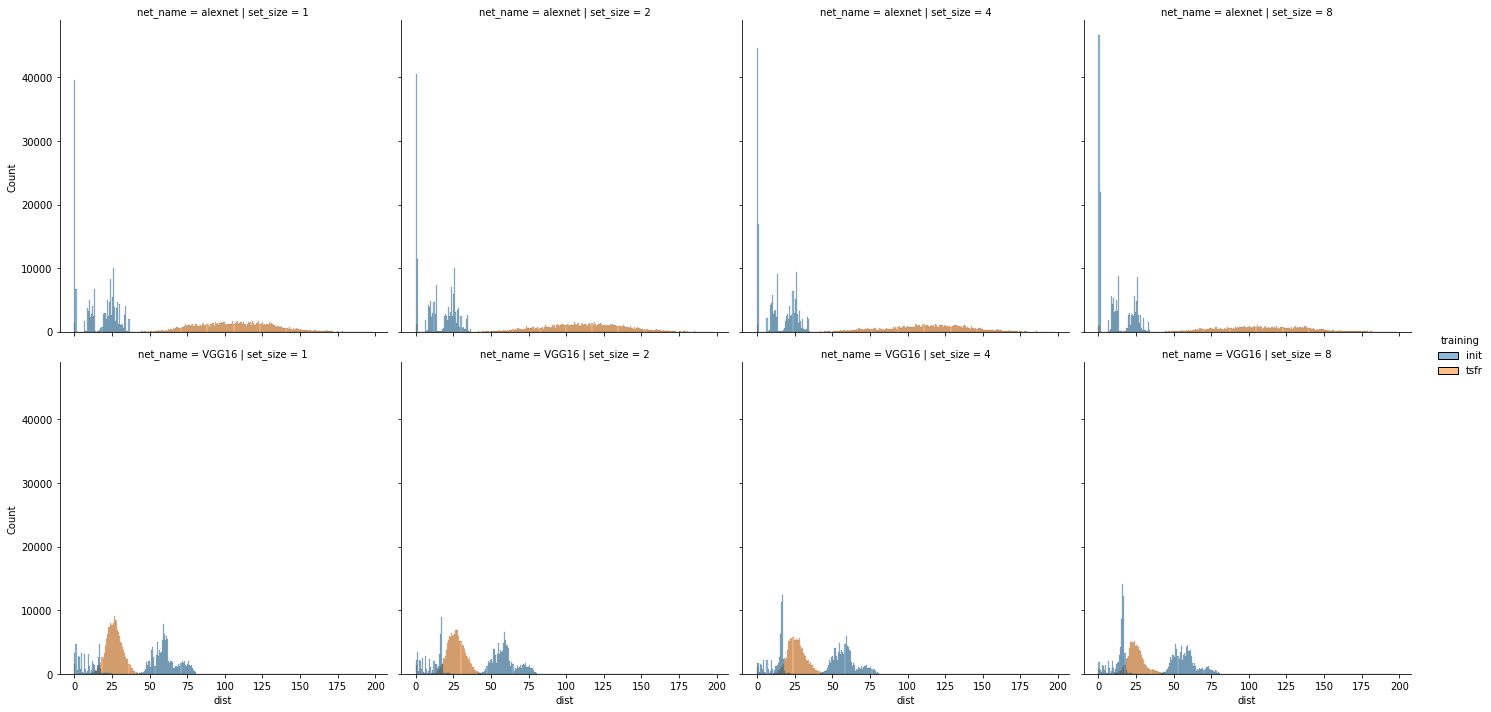

In [9]:
sns.displot(dist_data, x='dist', hue='training', row='net_name', col='set_size')